# PREPARATION


*   Import necessary libs
*   Connect Google Drive
*   Select dataset
*   Set pathes and global variables



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV I/O 
import os
from google.colab import drive
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import gc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import decomposition

In [ ]:
# MOUNT GOOGLE DRIVE

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# SELECT DATASET

cxr = False    # True - CXR dataset | False - CT dataset

In [ ]:
# PATHES

root = '/content/drive/MyDrive/Egyetem/Szakdolgozat/Code/Datasets/'
data_root = root + 'CXR/' if cxr else root + 'CT/'
train_path = data_root + 'train/'
validation_path = data_root + 'valid/'
test_path = data_root + 'test/'
checkpoint_path = '/content/drive/MyDrive/Egyetem/Szakdolgozat/Code/Classification/cp_teszt/'
checkpoint_path = checkpoint_path + 'best_cxr_classifier_' if cxr else checkpoint_path + 'best_ct_classifier_'

In [ ]:
# DEVICE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# LOAD DATA


*   Datasets: CXR, CT
*   Number of CXR images: 1960 (980 + 980)
*   Number of CT images: 746 (349 + 397)
*   Split: train - 80% | validation - 10% | test - 10%
*   Examples

In [ ]:
def load_data(path):
    images=[]
    labels=[]
    for file in os.listdir(path):
        if file=='normal':
            for im in os.listdir(os.path.join(path, file)):
                images.append(im)
                labels.append('normal')
        if file=='covid':
            for im in os.listdir(os.path.join(path, file)):
                images.append(im)
                labels.append('covid')

    data = {'Images':images, 'labels':labels} 
    data = pd.DataFrame(data)
    return data

In [ ]:
# LOAD DATA FOR TRAINING AND VALIDATION

# Train
train_data = load_data(train_path)
print(train_data.shape)
lb = LabelEncoder()
train_data['encoded_labels'] = lb.fit_transform(train_data['labels'])

# Validation
validation_data = load_data(validation_path)
print(validation_data.shape)
validation_data['encoded_labels'] = lb.fit_transform(validation_data['labels'])

(596, 2)
(75, 2)


In [ ]:
# LOAD DATA FOR TEST

# Test
test_data = load_data(test_path)
print(test_data.shape)
lb = LabelEncoder()
test_data['encoded_labels'] = lb.fit_transform(test_data['labels'])
test_data.head()

(75, 2)


,Images,labels,encoded_labels
0,covid_314.png,covid,0
1,covid_315.png,covid,0
2,covid_316.png,covid,0
3,covid_317.png,covid,0
4,covid_318.png,covid,0


In [ ]:
random_seed= 42
shuffle = True
batch_size = 32
transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()])

In [ ]:
def dataset_loader(data, path, transform, shuffle, random_seed, batch_size):
    dataset_size = len(data)
    indices = list(range(dataset_size))
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    sampler = SubsetRandomSampler(indices)
    dataset = CXR_Dataset(data, path, transform)
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=sampler)
    return dataset_loader

In [ ]:
class CXR_Dataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.convert('RGB')
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
train_loader = dataset_loader(train_data, train_path, transform, True, random_seed, batch_size)
validation_loader = dataset_loader(validation_data, validation_path, transform, True, random_seed, batch_size)

In [ ]:
test_loader = dataset_loader(test_data, test_path, transform, True, random_seed, batch_size)

torch.Size([32, 3, 224, 224])
torch.Size([32])


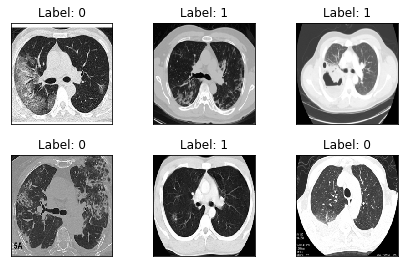

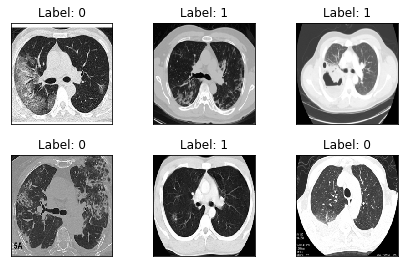

In [ ]:
# EXAMPLE 1

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

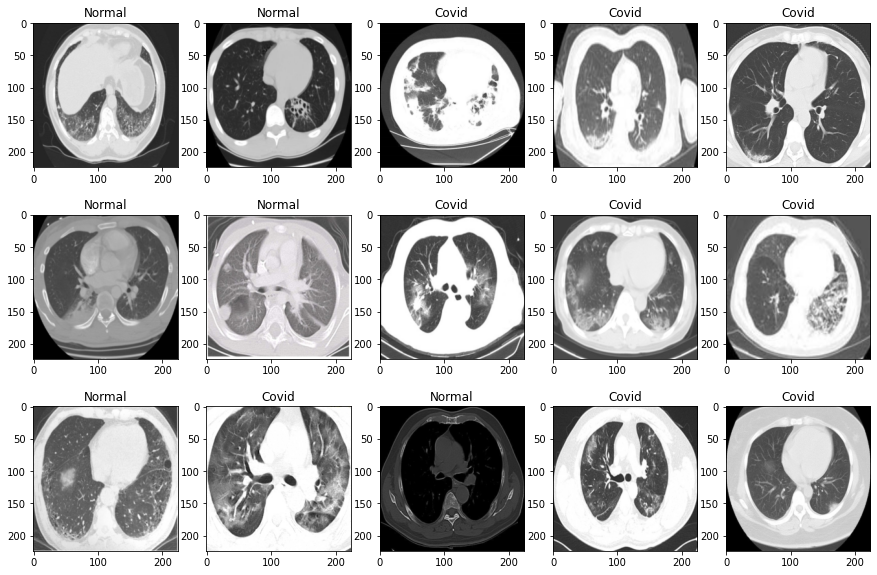

In [ ]:
# EXAMPLE 2

def img_display(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
cxr_types = {0: 'Covid', 1: 'Normal'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{cxr_types[label.item()]}") # add label

# BUILDTHE MODEL


*   VGG11 (not pretrained)
*   Binary image classification
*   Optimizer: Adam
*   Criterion: Cross Entropy 

In [ ]:
# VGG

class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        
        self.features = features
        
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )
        # classifier = torch.nn.ModuleList(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [ ]:
# VGG

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

In [ ]:
# VGG

def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

In [ ]:
# VGG

vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
#VGG

OUTPUT_DIM = 2
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# VGG

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

if device is not 'cpu':
    model = model.to(device)
    criterion = criterion.to(device)

# TRAIN THE MODEL


*   Batch size: 32
*   Number of epoch: 5
*   Saving best weights
*   Learnin curves (loss, accuracy)

In [ ]:
# FREE SPACE

gc.collect()
torch.cuda.empty_cache()

In [ ]:
def new_checkpoint(list, new):
    if len(list) == 0:
        old_best = 1000
    else:
        old_best = min(list)
    is_best = bool(new < old_best)
    return is_best

In [ ]:
# TRAIN

n_epochs = 16
print_every = 5 if cxr else 2
valid_loss_min = np.Inf
val_loss = []
val_acc = []
best_val_acc = 0
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data_, target_) in enumerate(train_loader):
        if device is not "cpu":
            data_, target_ = data_.to(device), target_.to(device)   # on GPU
        
        optimizer.zero_grad()   # zero the parameter gradients
        
        outputs, _ = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Train Epoch: {}/{}\t[{}/{} ({}%)]\tLoss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, int(100*(batch_idx/total_step)), loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\n==> Train Loss: {(running_loss/total_step):.4f}\tTrain Acc: {(100 * correct / total):.4f}%')
    
    # Validation
    model.eval()
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        for data_t, target_t in (validation_loader):

            if device is not "cpu":
                data_t, target_t = data_t.to(device), target_t.to(device)   # on GPU

            outputs_t, _ = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
    new_val_acc = 100 * correct_t / total_t
    new_val_loss = batch_loss/len(validation_loader)
    network_learned = new_checkpoint(val_loss, new_val_loss)
    val_acc.append(new_val_acc)
    val_loss.append(new_val_loss)
    # network_learned = batch_loss < valid_loss_min
    print(f'==> Valid Loss: {(new_val_loss):.4f}\tValid Acc: {new_val_acc:.4f}%\n')
    # Saving the best weight 
    if network_learned:
        checkpoint_name = str(int(10*new_val_loss)) + '_' + str(int(new_val_acc)) + '.pt'
        torch.save(model.state_dict(), checkpoint_path + checkpoint_name)
        print('==> Saving current model.\n')

Train Epoch: 1/16	[0/19 (0%)]	Loss: 0.7025
Train Epoch: 1/16	[2/19 (10%)]	Loss: 0.4906
Train Epoch: 1/16	[4/19 (21%)]	Loss: 0.3045
Train Epoch: 1/16	[6/19 (31%)]	Loss: 1.0450
Train Epoch: 1/16	[8/19 (42%)]	Loss: 0.6502
Train Epoch: 1/16	[10/19 (52%)]	Loss: 0.8285
Train Epoch: 1/16	[12/19 (63%)]	Loss: 0.2303
Train Epoch: 1/16	[14/19 (73%)]	Loss: 0.6570
Train Epoch: 1/16	[16/19 (84%)]	Loss: 0.3553
Train Epoch: 1/16	[18/19 (94%)]	Loss: 0.4181

==> Train Loss: 0.7334	Train Acc: 70.9732%
==> Valid Loss: 1.1965	Valid Acc: 68.0000%

==> Saving current model.

Train Epoch: 2/16	[0/19 (0%)]	Loss: 0.4515
Train Epoch: 2/16	[2/19 (10%)]	Loss: 0.5132
Train Epoch: 2/16	[4/19 (21%)]	Loss: 0.3218
Train Epoch: 2/16	[6/19 (31%)]	Loss: 0.3826
Train Epoch: 2/16	[8/19 (42%)]	Loss: 0.2823
Train Epoch: 2/16	[10/19 (52%)]	Loss: 0.3739
Train Epoch: 2/16	[12/19 (63%)]	Loss: 0.3384
Train Epoch: 2/16	[14/19 (73%)]	Loss: 0.1112
Train Epoch: 2/16	[16/19 (84%)]	Loss: 0.3912
Train Epoch: 2/16	[18/19 (94%)]	Loss: 0.09

KeyboardInterrupt: ignored

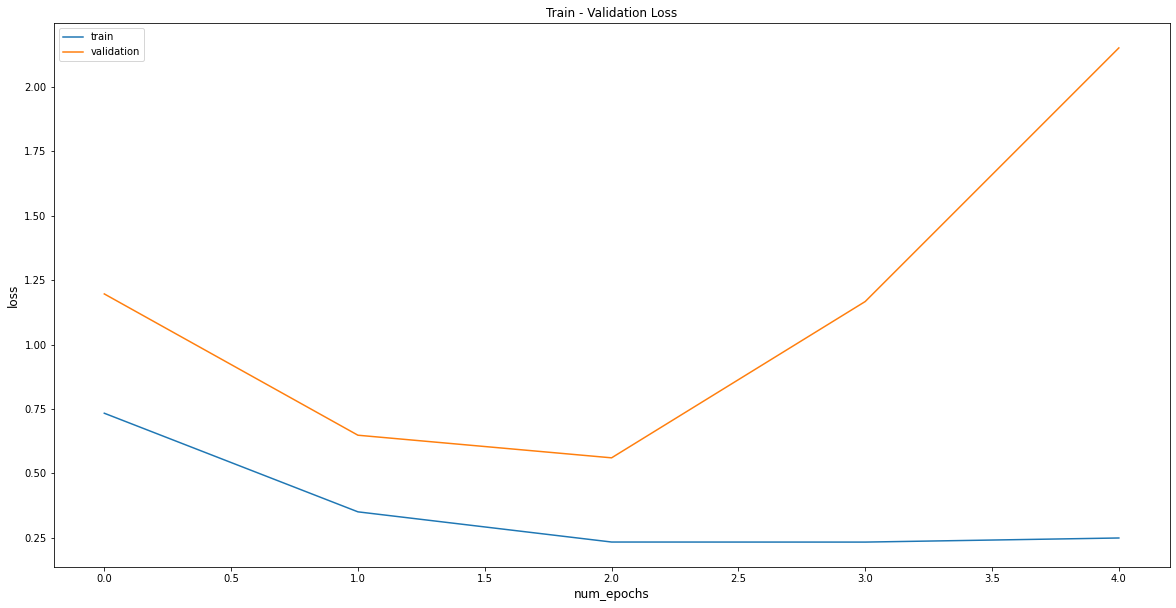

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

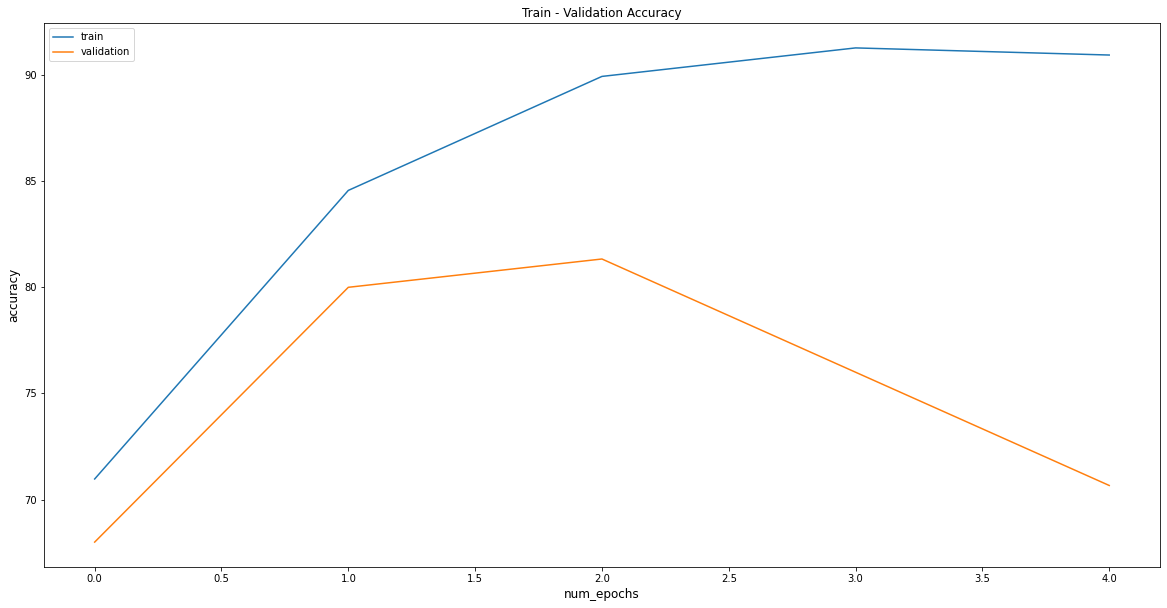

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

# RESULTS


*   Test the model
*   Confusion matrix
*   Most incorrect predictions
*   Principal component analysis (PCA)
*   Filtered images

In [ ]:
# LOAD THE BEST WEIGHTS

cp_name = '5_81.pt'
checkpoint = torch.load(checkpoint_path + cp_name, map_location ='cpu')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
# TEST

test_loss = []
test_acc = []
batch_loss = 0
total_t=0
correct_t=0

with torch.no_grad():
        model.eval()
        for data_t, target_t in (test_loader):

            if device is not "cpu":
                data_t, target_t = data_t.to(device), target_t.to(device)   # on GPU

            outputs_t, _ = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        new_test_acc = 100 * correct_t / total_t
        test_acc.append(new_test_acc)
        test_loss.append(batch_loss/len(test_loader))
        print(f'==> Test Loss: {np.mean(test_loss):.4f}\tTest Acc: {(100 * correct_t / total_t):.4f}%\n')

==> Test Loss: 0.4560	Test Acc: 82.6667%



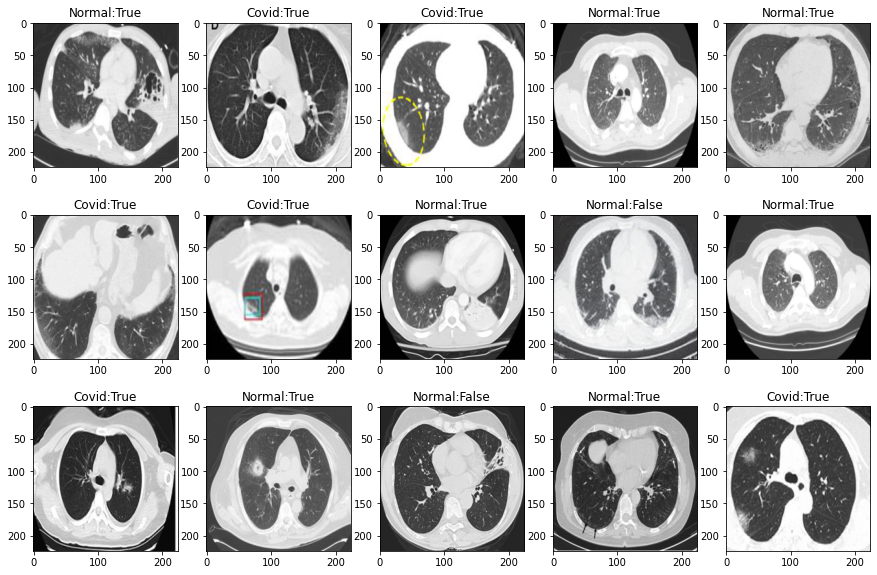

In [ ]:
def img_display(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

dataiter = iter(test_loader)
images, labels = dataiter.next()
image_types = {0: 'Covid', 1: 'Normal'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        if device is not "cpu":
            image_tensor = image_tensor.to(device) # on GPU
        output_, _ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(image_types[label.item()])+":" +str(k)) # add label

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_loader)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
print(pred_labels)

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1])


In [ ]:
classes = ['Normal', 'Covid']

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

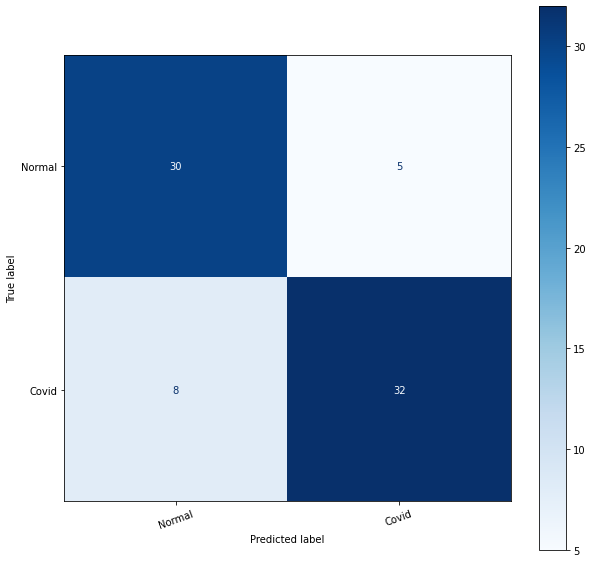

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
TP = 30   # True Normal
TN = 32   # True Covid
FP = 8    # False Normal
FN = 5   # False Covid

In [ ]:
# ACCURACY

accuracy = (TP + TN) / (TP + FP + TN + FN)
print('Accuraccy: ' + str(round(accuracy,2)))

Accuraccy: 0.83


In [ ]:
# PRECISION

n_precision = TP / (TP + FP)
c_precision = TN / (TN + FN)
print('Normal precision: ' + str(round(n_precision, 2)))
print('Covid precision: ' + str(round(c_precision, 2)))

Normal precision: 0.79
Covid precision: 0.86


In [ ]:
# SENSITIVITY

n_sensitivity = TP / (TP + FN)
c_sensitivity = TN / (TN + FP)
print('Normal sensitivity: ' + str(round(n_sensitivity, 2)))
print('Covid sensitivity: ' + str(round(c_sensitivity, 2)))

Normal sensitivity: 0.86
Covid sensitivity: 0.8


In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

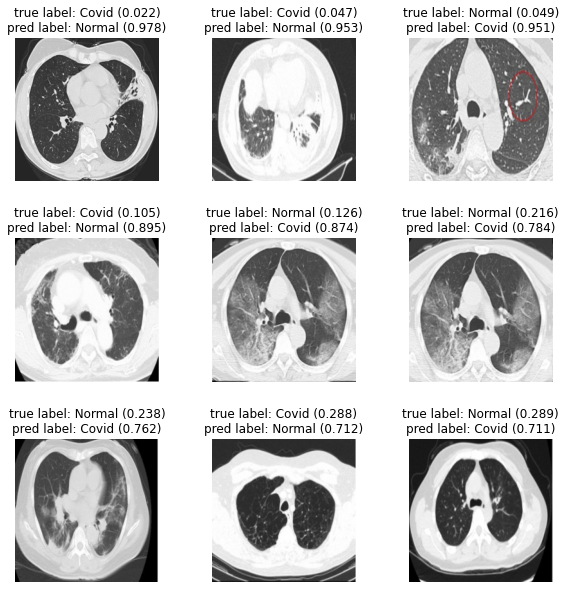

In [ ]:
N_IMAGES = 9

plot_most_incorrect(incorrect_examples, classes, N_IMAGES, False)

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
outputs, labels = get_representations(model, train_loader)

In [ ]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

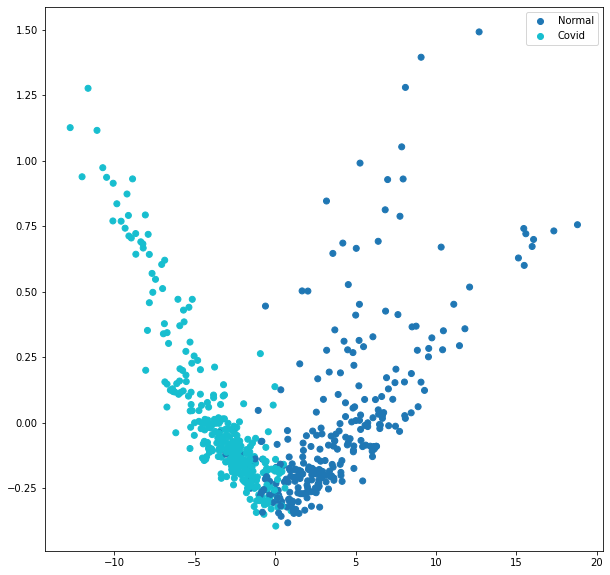

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = False):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

In [ ]:
test_data = CXR_Dataset(test_data, test_path, transform)

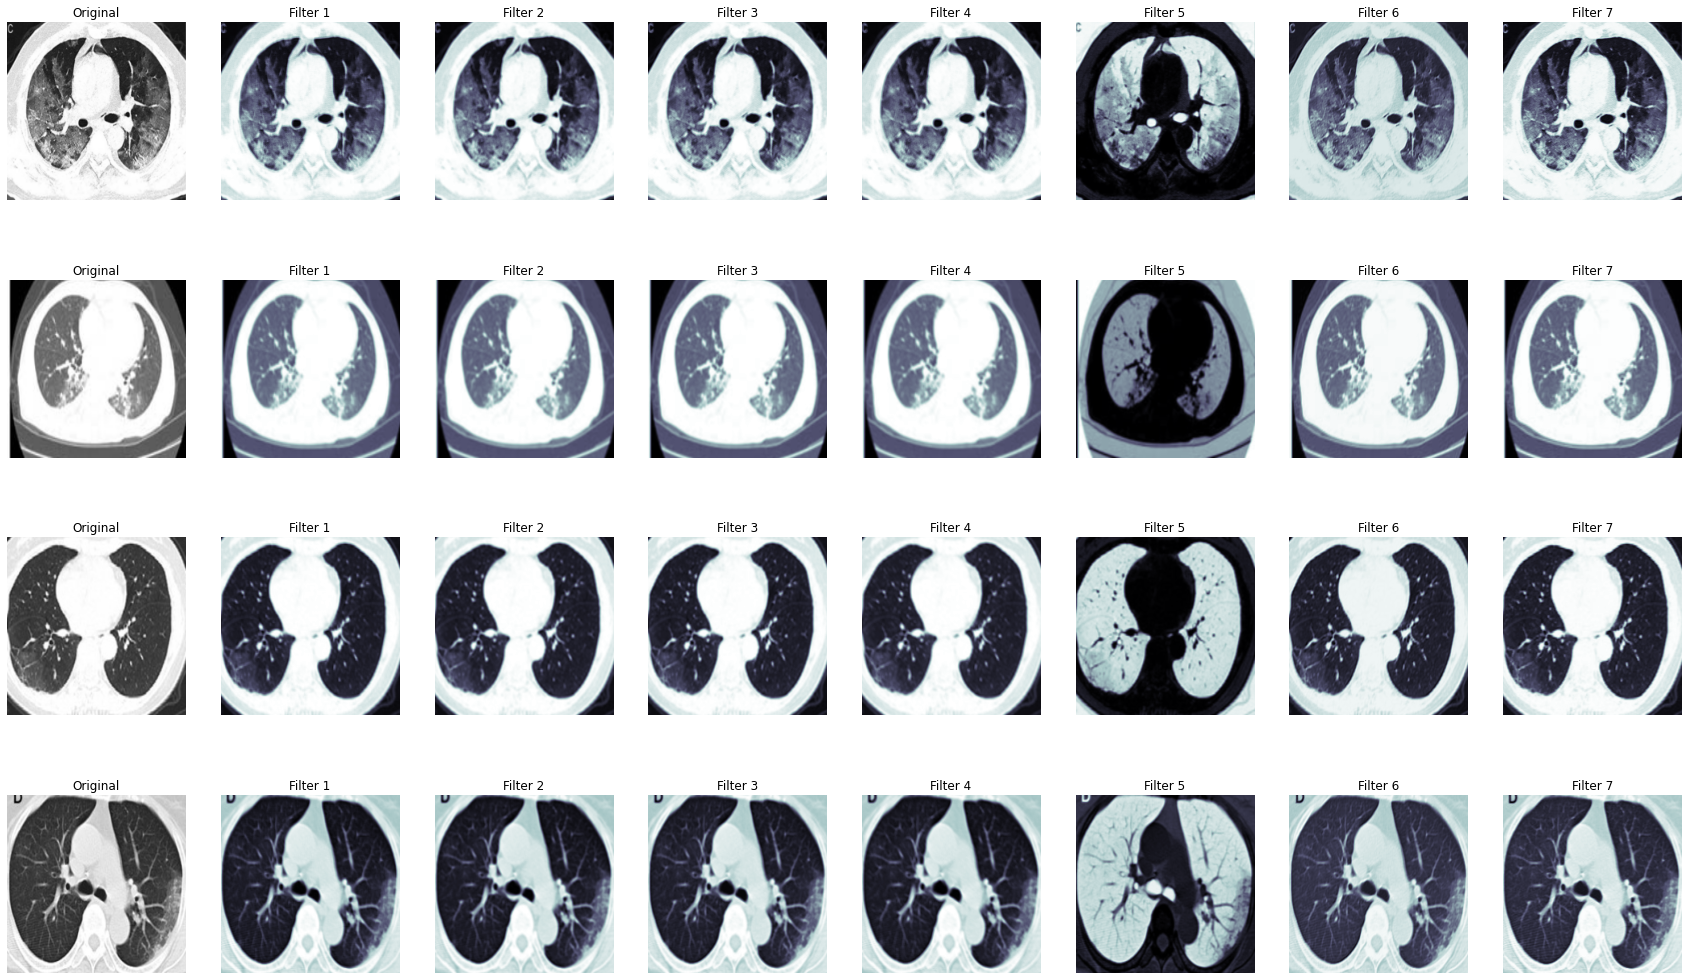

In [ ]:
N_IMAGES = 4
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)